In [1]:
import warnings
warnings.filterwarnings('ignore', 'numpy.dtype size changed')
warnings.filterwarnings( 'ignore', category=FutureWarning)

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
import numpy as np
from pyproj import Proj
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
date = datetime(2015, 1, 27, 0)

ds = xr.open_dataset('http://www.ncei.noaa.gov/thredds/dodsC/gfs-g4-anl-files/'
                     '{0:%Y%m}/{0:%Y%m%d}/gfsanl_4_{0:%Y%m%d}_{0:%H}00_000.grb2'.format(date))

#ds = xr.open_dataset('groundhogs_day_blizzard/GFS_{0:%Y%m%d}_{0:%H}00.nc'.format(date))

lats = ds.lat.data
lons = cutil.add_cyclic_point(ds.lon.data)

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(400,701)
lat_slice = slice(10,160)

lat1d = lats[lat_slice]
lon1d = lons[lon_slice]
lons, lats = np.meshgrid(lon1d, lat1d)

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

hght_dim_name = ds.Geopotential_height_isobaric.dims[1]
rhum_dim_name = ds.Relative_humidity_isobaric.dims[1]

ip100_3 = list(ds[hght_dim_name].values).index(10000)-1
ip100_5 = list(ds[rhum_dim_name].values).index(10000)-1

lev = ds[hght_dim_name].values[ip100_3:] * units.Pa

uwnd = ds['u-component_of_wind_isobaric'].data[0, ip100_3:, lat_slice, lon_slice] * (units.meter/units.seconds)
vwnd = ds['v-component_of_wind_isobaric'].data[0, ip100_3:, lat_slice, lon_slice] * (units.meter/units.seconds)
tmpk = ds['Temperature_isobaric'].data[0, ip100_3:, lat_slice, lon_slice] * units.K
relh = ds['Relative_humidity_isobaric'].data[0, ip100_5:, lat_slice, lon_slice] * units.percent

vtime = datetime.strptime(str(ds.Geopotential_height_isobaric.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

# Transform Coordinates ahead of time
tlatlons = mapcrs.transform_points(ccrs.PlateCarree(), lons, lats)
clons = tlatlons[:,:,0]
clats = tlatlons[:,:,1]

In [3]:
isentlevs = list(range(285, 331, 3)) * units.kelvin
wind_slice = (slice(None, None, 5), slice(None, None, 5))

isent_anal = mpcalc.isentropic_interpolation(isentlevs,
                                             lev,
                                             tmpk,
                                             relh,
                                             uwnd,
                                             vwnd,
                                             tmpk_out=True)

/Users/kgoebber/miniconda3/lib/python3.6/site-packages/metpy/interpolate/one_dimension.py:148: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


In [11]:
def plot_isentropic(level):
    print("Creating the {} K Level Maps".format(level))
    ilev = list(isentlevs.m).index(level)

    isentprs = mpcalc.smooth_n_point(isent_anal[0][ilev,:,:], 9, 5)
    isenttmp = mpcalc.smooth_n_point(isent_anal[1][ilev,:,:], 9, 5)
    isentrelh = mpcalc.smooth_n_point(isent_anal[2][ilev,:,:], 9, 5)
    isentu = mpcalc.smooth_n_point(isent_anal[3].to('kt')[ilev,:,:], 9, 5)
    isentv = mpcalc.smooth_n_point(isent_anal[4].to('kt')[ilev,:,:], 9, 5)


    fig = plt.figure(1, figsize=(17,15))

    # 1st panel
    ax = plt.subplot(111, projection=mapcrs)
    ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    cf = ax.contourf(clons, clats, isentrelh, range(70,101,1), cmap=plt.cm.Greens, norm=plt.Normalize(70,108))
    plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

    cs = ax.contour(clons, clats, isentprs, range(50,1001,50), colors='black')
    plt.clabel(cs, fmt='%d')

    ax.barbs(lons[wind_slice], lats[wind_slice],
             isentu[wind_slice].m, isentv[wind_slice].m,
             transform=ccrs.PlateCarree())

    plt.title('{} K Pressure (hPa), Relative Humidity (%), and Wind Barbs'.format(isentlevs[ilev].m), loc='left')
    plt.title('Valid Time: {}'.format(vtime), loc='right')

    plt.savefig('Isentropic_{0}K_{1:%Y%m%d_%H}00.png'.format(isentlevs[ilev].m,date))
    plt.show()
    plt.close()

Creating the 300 K Level Maps


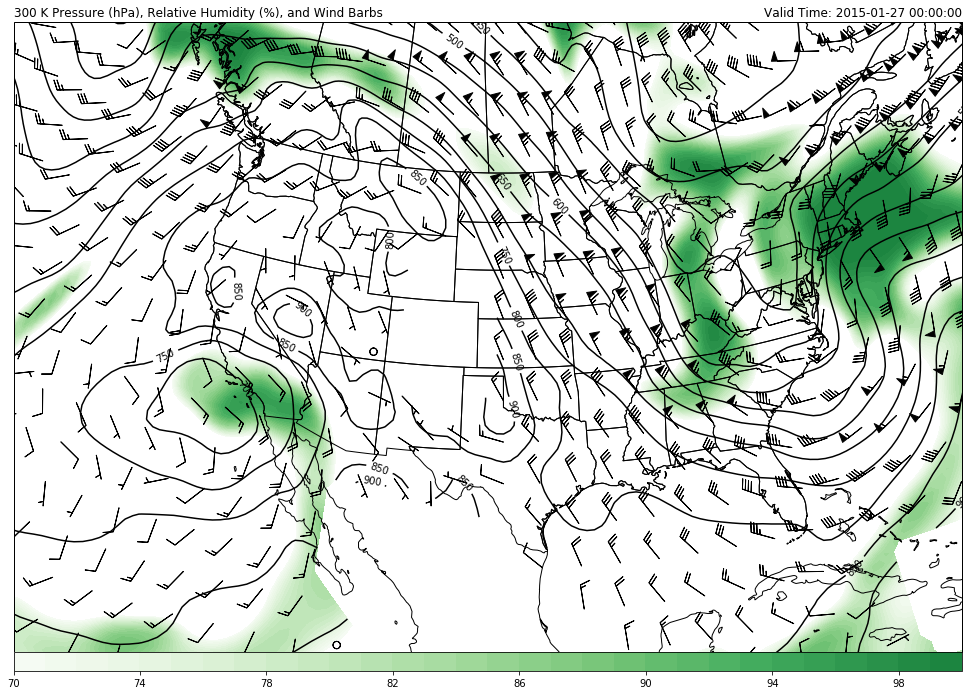

In [12]:
plot_isentropic(300)